In [6]:
import _init_lib_path

from datetime import datetime
import datetime as dt
import time

from utils.config import cfg
from epoch_loop import EpochLoop

import argparse
from utils.config_file_handling import cfg_from_file, cfg_from_list
from pprint import PrettyPrinter

pp = PrettyPrinter(indent=4)
cfg.TRAINING = True
import torch
torch.set_num_threads(32)
from tqdm.notebook import trange, tqdm
import numpy as np


from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Training the network')

    parser.add_argument('-d', '--dataset-dir', dest='dataset_dir',
                        help='dataset directory', type=str, required=False)
    parser.add_argument('-e', '--experiment-dir', dest='experiment_dir',
                        help='a directory used to write experiment results', type=str, required=False)
    parser.add_argument('-u', '--use-gpu', dest='use_gpu',
                        help='whether to use gpu for the net inference', type=int, required=False)
    parser.add_argument('-g', '--gpu-id', dest='gpu_id',
                        help='gpu id to use', type=int, required=False)
    parser.add_argument('-c', '--cfg', dest='cfg_file',
                        help='optional config file to override the defaults', default=None, type=str)
    parser.add_argument('-s', '--set', dest='set_cfg',
                        help='set config arg parameters', default=None, nargs=argparse.REMAINDER)
    return parser.parse_args([])


def set_positional_cfg(args_in):
    args_list = []
    for n, a in args_in.__dict__.items():
        if a is not None and n not in ['cfg_file', 'set_cfg']:
            args_list += [n, a]
    return args_list

args = parse_args()

# print('Called with args:')
# print(args)

if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)
if args.set_cfg is not None:
    cfg_from_list(args.set_cfg)

cfg_from_list(set_positional_cfg(args))     # input arguments override cfg files and defaults

# print('configuration file cfg is loaded for training ...')
# pp.pprint(cfg)

epoch_loop = EpochLoop()
started_time = time.time()
epoch_loop.create_sets()
epoch_loop.setup_net()

ep = 39
date = '20200603_213819_380274'
# ep =99
# data = '20200517_074837_564165'
epoch_loop.net.spatial_stream.load_state_dict(torch.load("../experiment/snapshot_UCF101_resnet/{date}/spt_0{ep}.pth".format(date=date, ep=ep)))
epoch_loop.net.temporal_stream.load_state_dict(torch.load("../experiment/snapshot_UCF101_resnet/{date}/tmp_0{ep}.pth".format(date=date, ep=ep)))

epoch_loop.validator.set_net_mode(epoch_loop.net)
epoch_loop.validator.reset_meters()


creating training sets...
creating validation sets...
setup nets...
creating load
setting up optimizer...


In [2]:
prediction_labels = []
gt_labels = []

for i, (image, flow, annotation) in enumerate(tqdm(epoch_loop.validator.data_container.dataloader)):
    image = image.to(epoch_loop.validator.device)
    flow = flow.to(epoch_loop.validator.device)
    with torch.no_grad():
        p = epoch_loop.net.forward(image, flow)
    if p[1] is None:
        p = p[0]
    else:
        p = torch.stack(p).mean(dim=0)
    pred_label = p.argmax(dim=1)
    prediction_labels += list(pred_label.cpu().numpy())
    
    ## gt
    a = epoch_loop.validator.generate_gt(annotation)
    gt_labels += list(a.cpu().numpy())
    
prediction_labels = np.array(prediction_labels)
gt_labels = np.array(gt_labels)
np.save('pred.npy', prediction_labels)
np.save('gt.npy', gt_labels)

In [7]:
prediction_labels = np.load('pred.npy')
gt_labels = np.load('gt.npy')

In [8]:
cm = confusion_matrix(gt_labels, prediction_labels)

<IPython.core.display.Javascript object>


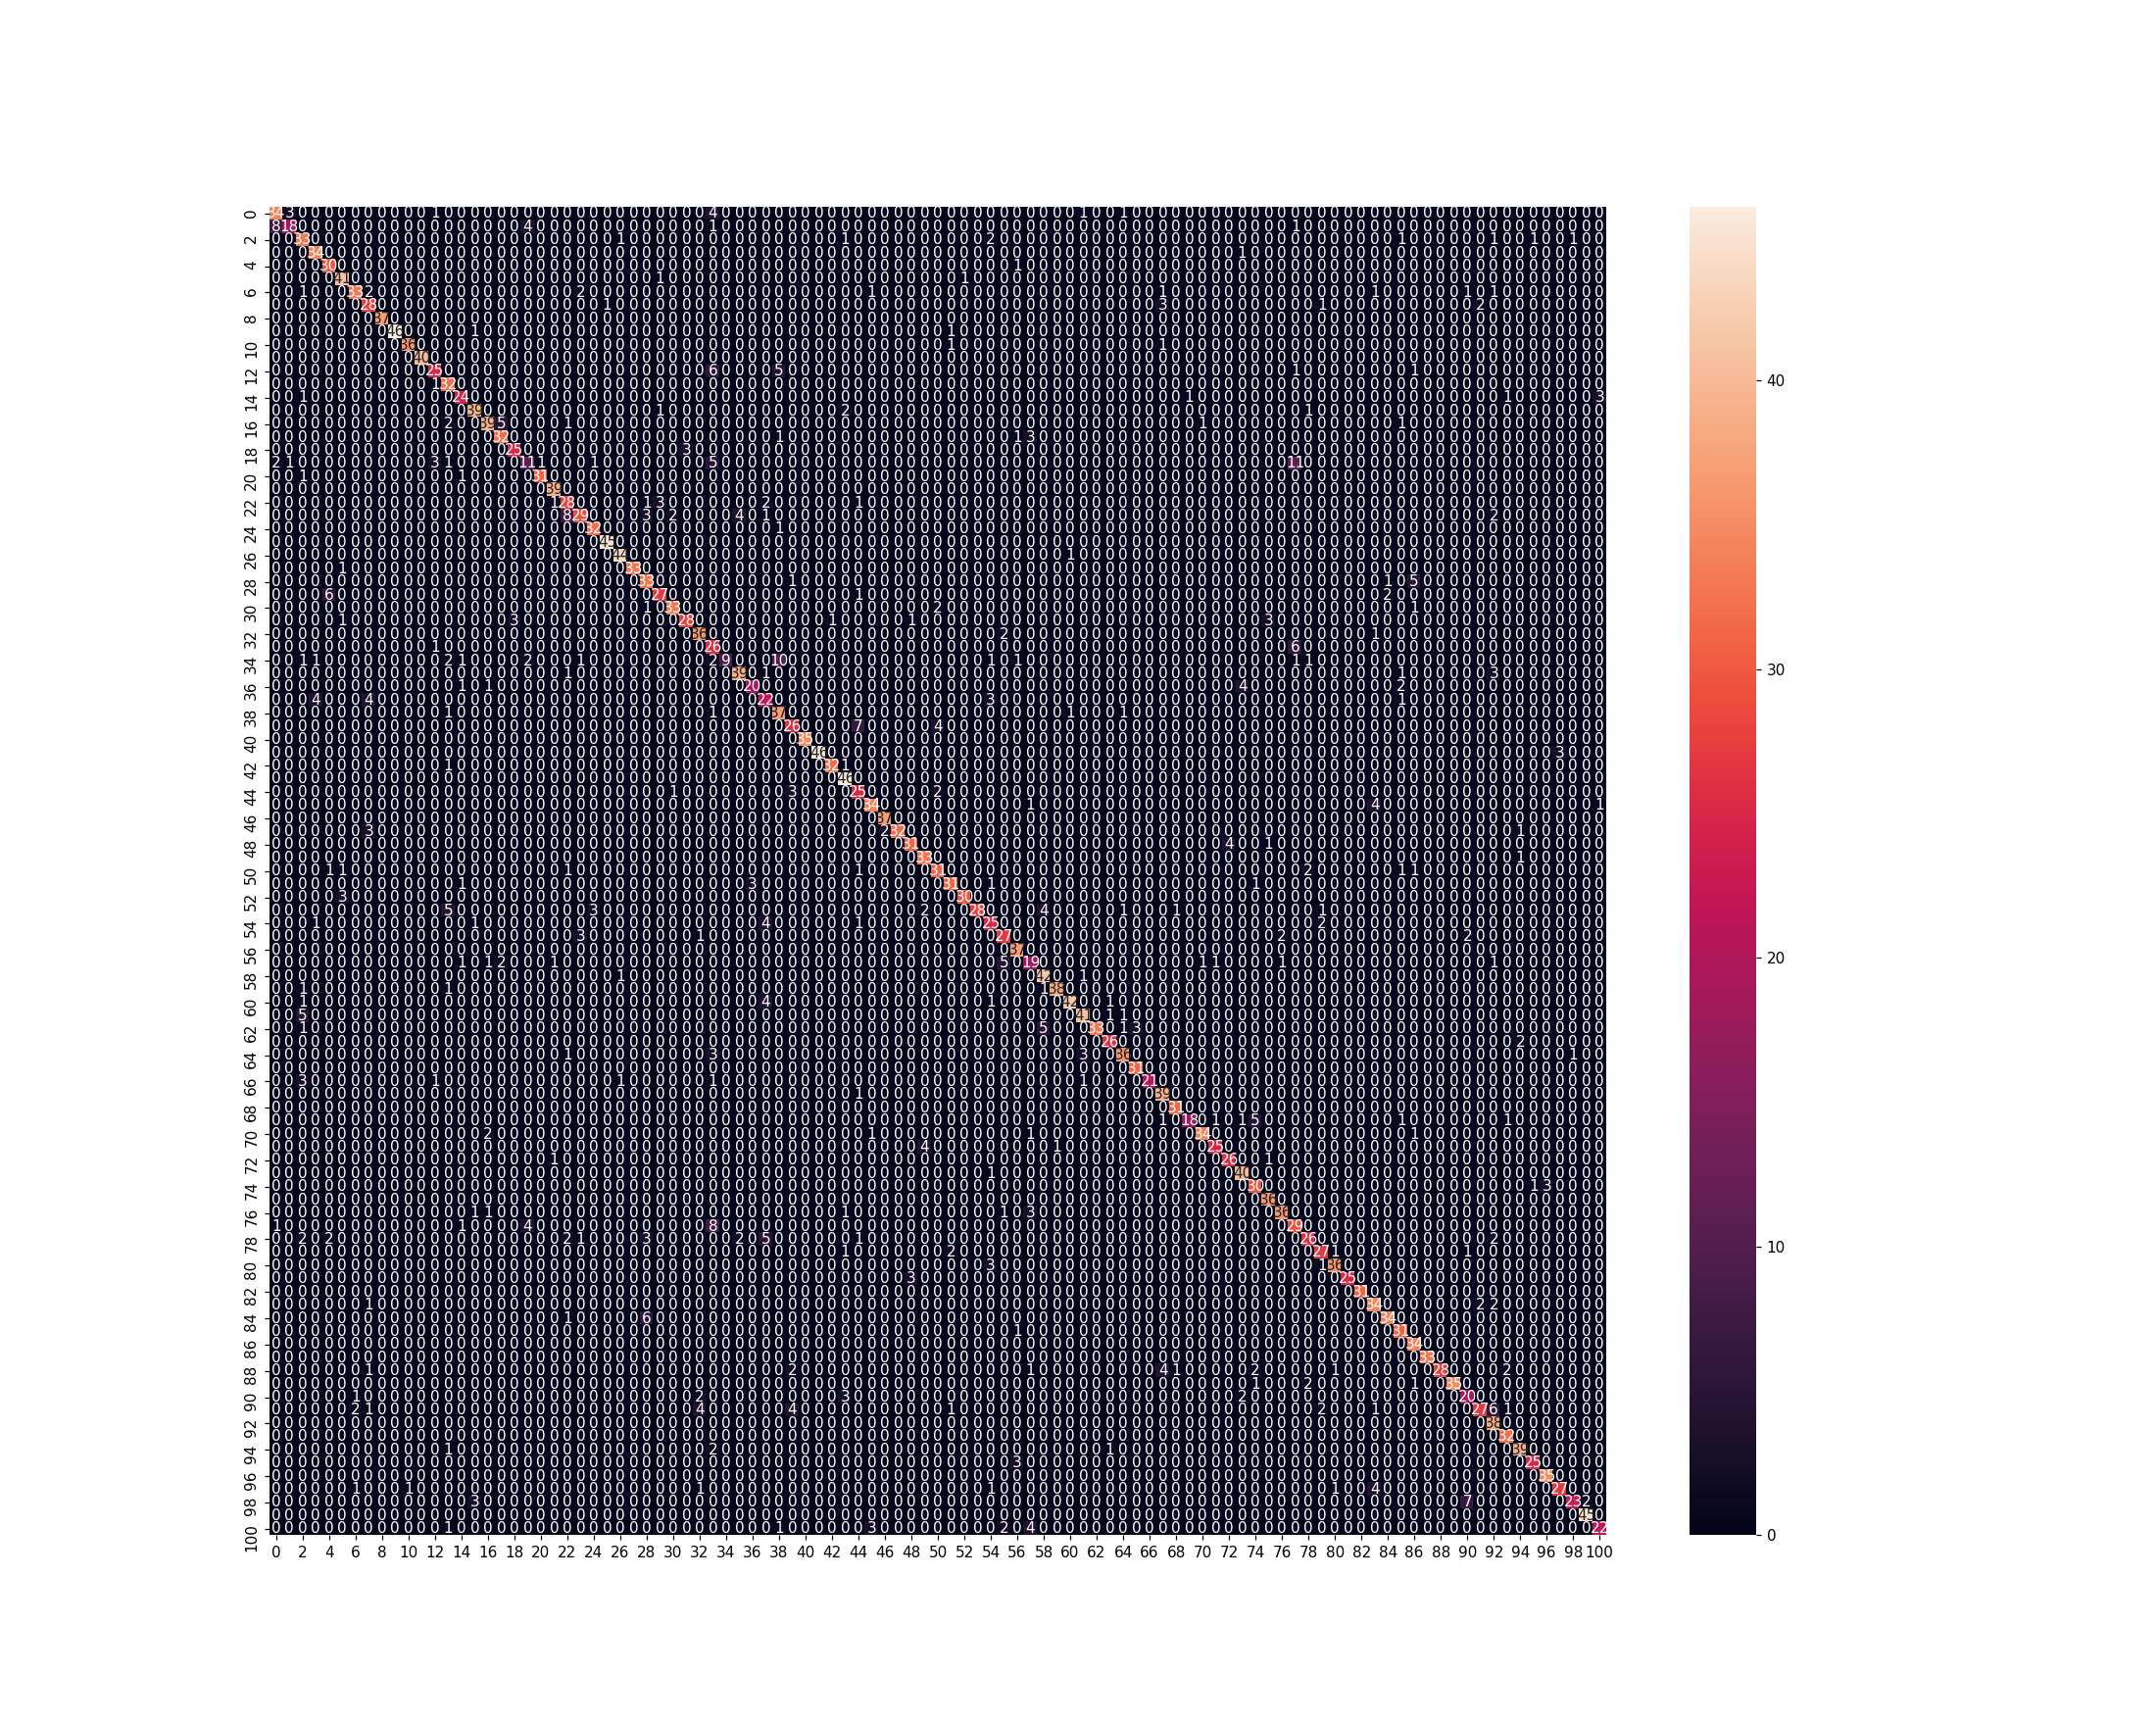

In [9]:
%matplotlib notebook
# !pip install seaborn

df_cm = pd.DataFrame(cm, index = [i for i in range(101)],
                  columns = [i for i in range(101)])
plt.figure(figsize = (20, 16))
sn.heatmap(df_cm, annot=True)

In [10]:
np.mean(prediction_labels == gt_labels)

0.8458686440677966

In [11]:
correct = np.zeros(101)
total = np.zeros(101)
for i in range(len(prediction_labels)):
    total[gt_labels[i]] += 1
    if prediction_labels[i] == gt_labels[i]:
        correct[gt_labels[i]] += 1
acc = correct / total

In [12]:
acc

array([0.77272727, 0.5625    , 0.80487805, 0.97142857, 0.96774194,
       0.95348837, 0.76744186, 0.8       , 1.        , 0.95833333,
       0.94736842, 1.        , 0.65789474, 0.96969697, 0.8       ,
       0.90697674, 0.79591837, 0.86486486, 0.89285714, 0.30555556,
       0.93939394, 1.        , 0.77777778, 0.59183673, 0.96969697,
       1.        , 0.97777778, 0.97058824, 0.825     , 0.75      ,
       0.89189189, 0.75675676, 0.92307692, 0.78787879, 0.27272727,
       0.86666667, 0.71428571, 0.64705882, 0.90243902, 0.7027027 ,
       1.        , 0.93877551, 0.94117647, 1.        , 0.80645161,
       0.85      , 1.        , 0.84210526, 0.86111111, 0.97058824,
       0.79487179, 0.83783784, 0.90909091, 0.62222222, 0.73529412,
       0.77142857, 1.        , 0.57575758, 0.95454545, 0.92682927,
       0.85714286, 0.85416667, 0.76744186, 0.92857143, 0.81818182,
       1.        , 0.75      , 0.975     , 1.        , 0.64285714,
       0.87179487, 0.83333333, 0.92857143, 0.97560976, 0.88235

In [38]:
np.where(acc <= 0.6)[0]
len(np.where(acc <= 0.6)[0])

7

In [21]:
"""
Load labels
"""
import os 
import pandas as pd
label_p = os.path.join('/home/srip19-pointcloud/linjun/dataset/ucf101/annotations', 'classInd.txt')
label_content = pd.read_csv(label_p, sep='delimiter', header=None, engine='python')
labels = {}
for i in range(len(label_content)):
    cls_id, cls_name = label_content.iloc[i, 0].split(' ')
    labels[int(cls_id)] = cls_name

In [31]:
inds = np.where(acc >= 1)[0]+1
res=''
for i in inds:
    res += labels[i]+', '
print(res)

BasketballDunk, Billiards, CliffDiving, Diving, HorseRace, IceDancing, JumpingJack, ParallelBars, PlayingTabla, PommelHorse, Rowing, SkyDiving, SumoWrestling, Surfing, ThrowDiscus, TrampolineJumping, VolleyballSpiking, WritingOnBoard, 


In [39]:
inds = np.where(acc <= 0.6)[0]

res=''
for i in inds:
    res += labels[i]+', '
print(res)

ApplyEyeMakeup, BreastStroke, CricketBowling, Haircut, ParallelBars, ShavingBeard, TaiChi, 


<IPython.core.display.Javascript object>


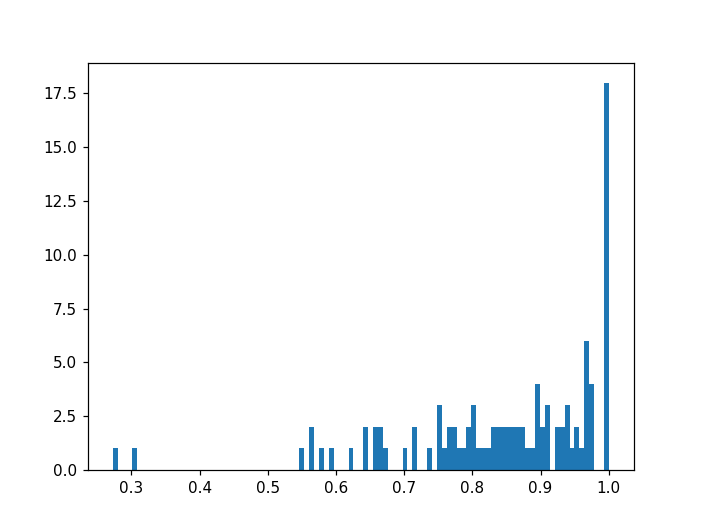

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,
         0.,  2.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  1.,
         0.,  3.,  1.,  2.,  2.,  1.,  1.,  2.,  3.,  1.,  1.,  1.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  4.,  2.,  3.,  0.,  2.,
         2.,  3.,  1.,  2.,  1.,  6.,  4.,  0.,  0., 18.]),
 array([0.27272727, 0.27992799, 0.28712871, 0.29432943, 0.30153015,
        0.30873087, 0.31593159, 0.32313231, 0.33033303, 0.33753375,
        0.34473447, 0.35193519, 0.35913591, 0.36633663, 0.37353735,
        0.38073807, 0.38793879, 0.39513951, 0.40234023, 0.40954095,
        0.41674167, 0.42394239, 0.43114311, 0.43834383, 0.44554455,
        0.45274527, 0.45994599, 0.46714671, 0.47434743, 0.48154815,
        0.48874887, 0

In [9]:
%matplotlib notebook
plt.hist(acc, bins=101)

# Top-5 Acc

In [10]:
pred_likelihood = []
gt_labels = []
counter = 0

for i, (image, flow, annotation) in enumerate(tqdm(epoch_loop.validator.data_container.dataloader)):
    image = image.to(epoch_loop.validator.device)
    flow = flow.to(epoch_loop.validator.device)
    with torch.no_grad():
        p = epoch_loop.net.forward(image, flow)
    if p[1] is None:
        p = p[0]
    else:
        p = torch.stack(p).mean(dim=0)
    pred_likelihood += list(p.cpu().numpy())
    
    ## gt
    a = epoch_loop.validator.generate_gt(annotation)
    gt_labels += list(a.cpu().numpy())
    
#     counter += 1
#     if counter > 5:
#         break

In [11]:
pred_likelihood = np.array(pred_likelihood)
np.save('pred_likelihood.npy', pred_likelihood)

In [12]:
top_five_pred = np.argsort(-pred_likelihood)[:, :5]

In [13]:
gt_labels = np.array(gt_labels)
top_five_count = 0

for i in gt_labels:
    if gt_labels[i] in top_five_pred[i]:
        top_five_count += 1
top_five_count / top_five_pred.shape[0]

0.972457627118644

In [40]:
labels

{1: 'ApplyEyeMakeup',
 2: 'ApplyLipstick',
 3: 'Archery',
 4: 'BabyCrawling',
 5: 'BalanceBeam',
 6: 'BandMarching',
 7: 'BaseballPitch',
 8: 'Basketball',
 9: 'BasketballDunk',
 10: 'BenchPress',
 11: 'Biking',
 12: 'Billiards',
 13: 'BlowDryHair',
 14: 'BlowingCandles',
 15: 'BodyWeightSquats',
 16: 'Bowling',
 17: 'BoxingPunchingBag',
 18: 'BoxingSpeedBag',
 19: 'BreastStroke',
 20: 'BrushingTeeth',
 21: 'CleanAndJerk',
 22: 'CliffDiving',
 23: 'CricketBowling',
 24: 'CricketShot',
 25: 'CuttingInKitchen',
 26: 'Diving',
 27: 'Drumming',
 28: 'Fencing',
 29: 'FieldHockeyPenalty',
 30: 'FloorGymnastics',
 31: 'FrisbeeCatch',
 32: 'FrontCrawl',
 33: 'GolfSwing',
 34: 'Haircut',
 35: 'Hammering',
 36: 'HammerThrow',
 37: 'HandstandPushups',
 38: 'HandstandWalking',
 39: 'HeadMassage',
 40: 'HighJump',
 41: 'HorseRace',
 42: 'HorseRiding',
 43: 'HulaHoop',
 44: 'IceDancing',
 45: 'JavelinThrow',
 46: 'JugglingBalls',
 47: 'JumpingJack',
 48: 'JumpRope',
 49: 'Kayaking',
 50: 'Knitting',